In [1]:
import cobra
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mpc
import seaborn as sns
import numpy as np
dcolors = plt.cm.tab10.colors
from pathlib import Path
import sys
sys.path.append('../../../code/')
import leakage
from scipy.stats import linregress
import scipy.stats as st
from matplotlib import cm, colors
import matplotlib.lines as mlines
sns.set_theme(font_scale = 1, style = 'ticks')
import reframed
import matplotlib.lines as mlines


# Figure 1A: metabolite time courses


In [2]:
git_folder = Path('../../..')
figure_folder = git_folder / 'Figures'

In [3]:
folder_paczia_ecoli = git_folder / 'data' / 'paczia_2012' / 'e_coli'
df_exometabolites, df_exometabolites_std = leakage.get_concentrations(folder_paczia_ecoli, 'e_coli')

In [4]:
fn_OD = folder_paczia_ecoli / 'e_coli_od.csv'
df_OD = pd.read_csv(fn_OD, index_col=0)

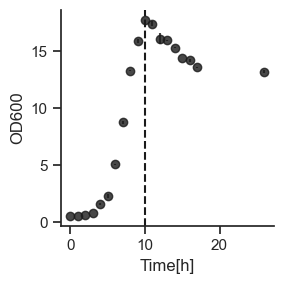

In [5]:
fig, ax = plt.subplots(1, figsize = (3,3))
plt.errorbar(df_OD.index, df_OD['OD mean'], yerr = df_OD['OD std'],  ls='none', marker = 'o', ms = 6, 
             color = 'k', alpha = 0.8)
plt.xlabel('Time[h]')
plt.ylabel('OD600')
plt.axvline(10, ls = '--', c = 'k')
sns.despine()
plt.tight_layout()
plt.savefig(figure_folder / 'ecoli_od.pdf')

In [6]:
m_abbr_to_name = {
    'LEU': 'L-Leucine',
    'R5P': 'Ribose 5-phosphate',
    'PYR': 'Pyruvate'
}

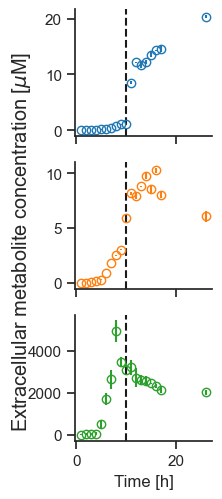

In [7]:
fig, axes = plt.subplots(3,1, figsize = (2.2,5), sharex=True)
for i, (abbr, name) in enumerate(m_abbr_to_name.items()):
    time = df_exometabolites.index
    conc = df_exometabolites[abbr]
    conc_std = df_exometabolites_std[abbr]
    # ax.plot(prod_rates, growth_rates, color = colors[i], label = r_ex_name, lw = 2)
    # axes[i].errorbar(time, conc, yerr = conc_std, color = dcolors[i], ls='none', marker = 'o', 
    #                  ms = 4, alpha = 0.8)

    axes[i].errorbar(time, conc, yerr = conc_std, ls='none', marker = 'o', 
                 ms = 6, markerfacecolor = 'none', markeredgecolor = dcolors[i], ecolor = dcolors[i])#alpha = 0.8
    axes[i].axvline(10, ls = '--', c = 'k')
    plt.tight_layout()
fig.supylabel(r'Extracellular metabolite concentration [$\mu$M]', x = 0)
axes[i].set_xlabel('Time [h]', size = 12)
sns.despine()
plt.subplots_adjust(bottom = 0.1)
plt.savefig(figure_folder /'concentration_curves.pdf')

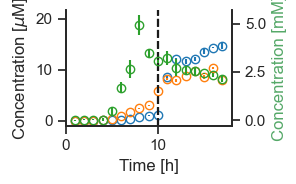

In [8]:
fig, ax1 = plt.subplots(1,1, figsize = (3,2))
ax2 = ax1.twinx()

for i, (abbr, name) in enumerate(m_abbr_to_name.items()):
    time = df_exometabolites.index
    conc = df_exometabolites[abbr]
    conc_std = df_exometabolites_std[abbr]
    # ax.plot(prod_rates, growth_rates, color = colors[i], label = r_ex_name, lw = 2)
    # axes[i].errorbar(time, conc, yerr = conc_std, color = dcolors[i], ls='none', marker = 'o', 
    #                  ms = 4, alpha = 0.8)
    if name =='Pyruvate':
        ax = ax2
        conc = conc*1e-3
        conc_std = conc_std*1e-3
    else:
        ax = ax1
    ax.errorbar(time, conc, yerr = conc_std, ls='none', marker = 'o', 
                 ms = 6, markerfacecolor = 'none', markeredgecolor = dcolors[i], ecolor = dcolors[i])#, alpha = 0.8)
    ax.axvline(10, ls = '--', c = 'k')
    plt.tight_layout()
# fig.supylabel(r'Extracellular metabolite concentration [$\mu$M]', x = 0)
plt.xlim(0, 18)
ax1.set_xlabel('Time [h]', size = 12)
ax1.set_ylabel(r'Concentration [$\mu$M]', size = 12)
ax2.set_ylabel(r'Concentration [mM]', size = 12, c = 'C2')
# plt.subplots_adjust(bottom = 0.1)
plt.tight_layout()
sns.despine(right = False)
plt.savefig(figure_folder / 'concentration_curves_2.pdf')

# Figure 1A: Production envelopes

In [9]:
model_fn = git_folder / 'models/e_coli/momentiJO1366_modified.xml'
# model = cobra.io.read_sbml_model(model_fn)
model = reframed.load_cbmodel(model_fn)
model.solver = 'gurobi'
glucose_uptake = -7.04

In [10]:
sol = reframed.FBA(model, constraints={'R_EX_glc__D_e':glucose_uptake})

Set parameter Username
Set parameter LicenseID to value 2586336
Academic license - for non-commercial use only - expires 2025-11-18


In [11]:
def make_flux_envelope(model, met_id, nx = 20):
    r_str = f'R_temp_sink: {met_id} <->  [0,1000]'
    model.add_reaction_from_str(r_str)
    sol1 = reframed.FBA(model, constraints={'R_EX_glc__D_e':glucose_uptake}, objective='R_temp_sink')
    max_prod = sol1.fobj
    print(met_id, max_prod)
    prod_rates = np.linspace(0, max_prod, nx, endpoint=True)
    growth_rates = np.zeros(nx)
    for i, p in enumerate(prod_rates):
        soli = reframed.FBA(model, objective=model.biomass_reaction, 
                            constraints={'R_EX_glc__D_e':glucose_uptake, 'R_temp_sink':(p,p*1.00001)})
        growth_rates[i] = soli.fobj
    return growth_rates, prod_rates

In [12]:
sol.show_values('R_EX')

R_EX_ca2_e   -0.00325577
R_EX_cl_e    -0.00325577
R_EX_co2_e    16.5639
R_EX_cobalt2_e -1.56377e-05
R_EX_cu2_e   -0.000443486
R_EX_fe2_e   -0.0100463
R_EX_glc__D_e -7.04
R_EX_h_e      5.74732
R_EX_h2o_e    33.0834
R_EX_k_e     -0.122095
R_EX_meoh_e   1.25102e-06
R_EX_mg2_e   -0.00542629
R_EX_mn2_e   -0.000432227
R_EX_mobd_e  -8.06906e-05
R_EX_nh4_e   -6.75601
R_EX_ni2_e   -0.000202039
R_EX_o2_e    -15.2291
R_EX_pi_e    -0.603385
R_EX_so4_e   -0.15776
R_EX_zn2_e   -0.000213299


M_leu__L_c 2.587613295632955
M_r5p_c 7.720000000000001
M_pyr_c 16.083125000000003


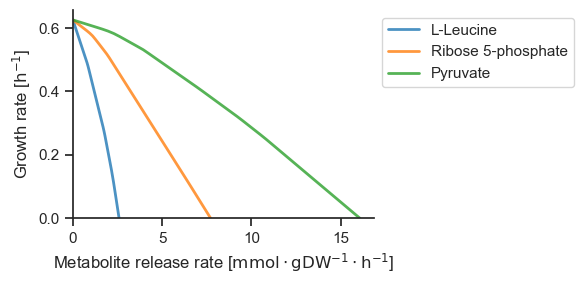

In [13]:

m_id_to_name = {
    'M_leu__L_c': 'L-Leucine',
    'M_r5p_c': 'Ribose 5-phosphate',
    'M_pyr_c': 'Pyruvate'
}
# sns.set(font_scale = 1.5)
fig, ax = plt.subplots(1, figsize = (6,3))
for i, (met_id, met_name) in enumerate(m_id_to_name.items()):
    growth_rates, prod_rates = make_flux_envelope(model, met_id, nx = 50)
    ax.plot(prod_rates, growth_rates, color = dcolors[i], label = met_name, lw = 2, alpha = 0.8)

n_above = np.sum(growth_rates>growth_rates[0]*0.8)
# ax.axhline(growth_rates[0]*0.9, ls = '--', c = 'k', label = 'Suboptimal threshold')
x = np.linspace(0, prod_rates[n_above-1], n_above)
# ax.plot(x, np.ones(n_above)*growth_rates[0]*0.9, ls = '--', c = 'k', label = 'Suboptimal threshold')
# ax.fill_between(x, np.ones(n_above)*growth_rates[0]*0.8, growth_rates[:n_above],
#                 alpha = 0.7, color = 'lightgray', label = 'Suboptimal region', zorder = 0)
plt.legend(loc = 'upper left', bbox_to_anchor = (1,1))
ax.set_xlim(0,None)
ax.set_ylim(0,None)
ax.set_ylabel(r'Growth rate [$\rm{h^{-1}}$]')
ax.set_xlabel(r'Metabolite release rate [$\rm{mmol \cdot gDW^{-1} \cdot h^{-1}}$]')
sns.despine()
plt.tight_layout()
plt.savefig(figure_folder / '1B_production_envelope_raw_no_suboptimal_region.pdf')


# Figure 1B: Rate estimations
See notebook 2B

# Figure 1C: Plot leakage rates
Plot leakage rates release rates and metabolite values. Estimated from batch cultures in this project, Paczia et al., 2012 and Vila et al. 2023

In [14]:
fn = git_folder / 'data' / 'other'/'A_rates_and_values.csv'
df_rates = pd.read_csv(fn, index_col=0)
df_rates = df_rates.loc[~df_rates['Rate [mmol/gDW/h]'].isna()]

In [15]:
fn_classification = git_folder / 'data'/'this_project'/'5_div'/'5D_classyfire_classification.csv'
df_classyfire = pd.read_csv(fn_classification, index_col=0)


## Define metabolite class

In [16]:
class_dict = {}
for i, row in df_classyfire.iterrows():
    if row['Class'] == 'Carboxylic acids and derivatives':
        if row['Subclass'] == 'Amino acids, peptides, and analogues':
            class_dict[row['Metabolite']] = 'Amino acids'
        else:
            class_dict[row['Metabolite']] = 'Carboxylic acids'
    elif row['Class'] == 'Organooxygen compounds':
        class_dict[row['Metabolite']] = 'Organooxygen compounds'
    elif row['Class'] in ['Keto acids and derivatives', 'Hydroxy acids and derivatives']:
        class_dict[row['Metabolite']] = 'Keto / hydroxy acids'
    else:
        class_dict[row['Metabolite']] = 'Other'
        

In [17]:
df_classyfire['Defined class'] = df_classyfire.Metabolite.map(class_dict)

In [18]:
df_classyfire.to_csv(fn_classification)

In [19]:
df_rates['Compound class'] = df_rates.Metabolite.map(class_dict)

# Remove datapoints where log10 rates are np.nan

In [20]:
df_rates.replace([-np.inf, np.inf], np.nan, inplace=True)

In [21]:
df_rates = df_rates.loc[~df_rates['log10(Rate [mmol/gDW/h])'].isna()].copy()

# Add error estimates

In [22]:
df_rates['rate+err'] = df_rates['Rate [mmol/gDW/h]']+df_rates['Std. Err [mmol/gDW/h]']
df_rates['rate-err'] = df_rates['Rate [mmol/gDW/h]']-df_rates['Std. Err [mmol/gDW/h]']

df_rates['log10(rate+err)'] = np.log10(df_rates['rate+err'])-df_rates['log10(Rate [mmol/gDW/h])']
df_rates['log10(rate-err)'] = df_rates['log10(Rate [mmol/gDW/h])'] - np.log10(df_rates['rate-err'])

/Users/snorre/miniconda3/envs/reframed/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Plot paczia first


In [23]:
df_p = df_rates.loc[df_rates.Dataset == 'Paczia-13', :].copy()
# yerr = np.array(list(zip(df_p['log10(rate-err)'], df_p['log10(rate+err)']))).T
yerr = np.array(list(zip(df_p['rate-err'], df_p['rate+err']))).T

In [24]:
df_p.loc[df_p['rate-err']<0]

,Metabolite,Carbon source,Rate [mmol/gDW/h],Std. Err [mmol/gDW/h],Metabolite value [gDW/mmol],N carbons,Mol weight [g/mol],Turnover [mmol/gDW/h],Species,Dataset,...,log10(Rate [mmol C/gDW/h]),log10(Rate [g/gDW/h]),log10(Metabolite value [gDW/mmol C]),log10(Metabolite value [gDW/g]),log10(Turnover [mmol/gDW/h]),Species - Carbon source,rate+err,rate-err,log10(rate+err),log10(rate-err)
755,Tryptophan,Glucose,9.147559e-08,3.297379e-07,0.176810,11.0,204.22518,0.016777,B. licheniformis,Paczia-13,...,-5.997302,-7.728585,-1.793886,-0.062603,-1.775288,B. licheniformis - Glucose,4.212134e-07,-2.382623e-07,0.663197,NaN
770,Uracil,Glucose,4.561839e-04,1.154177e-03,0.161073,4.0,112.08676,0.000000,S. cerevisiae,Paczia-13,...,-2.738800,-4.291306,-1.395038,0.157468,NaN,S. cerevisiae - Glucose,1.610360e-03,-6.979927e-04,0.547783,NaN


In [25]:
cmap = plt.cm.tab10
cclass_color = {'Carboxylic acids':cmap(0), 'Amino acids':cmap(1), 'Organooxygen compounds':cmap(2),
                'Keto / hydroxy acids':cmap(3), 'Other':cmap(4)}
# cclass_color = {'Organic acid':'C0', 'Amino acid':'C1', 'Phosphorylated sugar':'C2', 'Other':'C3'}

In [26]:
def linear_fit(slope, intercept, x, n = 20, xmin = None, xmax = None):
    if xmin is None:
        xmin = x.min()
    if xmax is None:
        xmax = x.max()
    xarr = np.linspace(xmin, xmax, n, endpoint=True)
    yarr = intercept + slope*xarr
    return xarr, yarr, 10**xarr, 10**yarr

E. coli
E. coli -2.1481089404629357 -6.246378371741388 -0.5257477225790833 0.0006993955216711763 -0.5257477225790834 0.0006993955216711747
B. licheniformis
B. licheniformis -4.179923468540944 -8.436895242555622 -0.7047926533244306 1.5996409001065852e-06 -0.7047926533244308 1.5996409001065636e-06
S. cerevisiae
S. cerevisiae -1.1181532245318662 -5.735847736862955 -0.6862666605587879 0.00015210569069779178 -0.6862666605587879 0.0001521056906977918
C. glutamicum
C. glutamicum 0.7748569491497258 -2.61818164077204 0.0967642408854766 0.6764893949946462 0.09676424088547658 0.6764893949946466


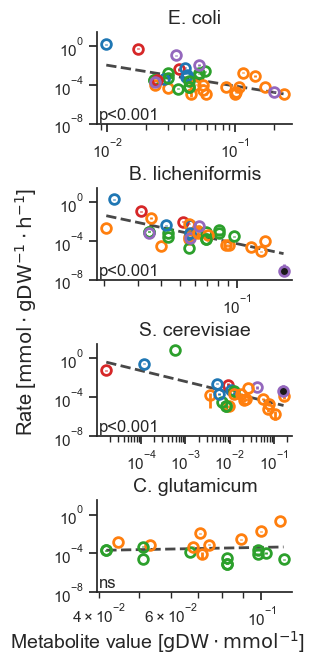

In [27]:
sns.set(font_scale = 1, style = 'ticks')
fig, axes = plt.subplots(4,1, figsize = (3, 7), sharey=True)
species_list = ["E. coli", "B. licheniformis", "S. cerevisiae", "C. glutamicum"]
# for i, species in enumerate(df_p.Species.unique()):
for i, species in enumerate(species_list):
    print(species)
    nanidx = df_p[['log10(Metabolite value [gDW/mmol])','log10(Rate [mmol/gDW/h])']].isna().any(axis = 1)
    idxs = (df_p.Species == species) & ~nanidx
    
    pcolors = df_p.loc[idxs, 'Compound class'].map(cclass_color).values
    x = df_p.loc[idxs, 'Metabolite value [gDW/mmol]'].values
    logx = df_p.loc[idxs, 'log10(Metabolite value [gDW/mmol])'].values
    y = df_p.loc[idxs, 'Rate [mmol/gDW/h]'].values
    logy = df_p.loc[idxs, 'log10(Rate [mmol/gDW/h])'].values
    # yierr = yerr[:, idxs]
    yierr = df_p.loc[idxs, 'Std. Err [mmol/gDW/h]'].values
    yierr2 = np.array(list(zip(yierr, yierr))).T
    # axes[i].set_xlim(np.min(x)*1.2, np.max(x)*0.5)
    for j in range(idxs.sum()):
        yjerr = yierr2[:, j, np.newaxis]
        if yjerr[0] > y[j]:
            yjerr[0] = 0
            markerfacecolor = 'k'
        else:
            markerfacecolor = 'none'
        axes[i].errorbar(x[j], y[j], yerr = yjerr,  ls = 'none', marker = 'o', c = pcolors[j], zorder = 0, 
                         markeredgecolor=pcolors[j], markerfacecolor=markerfacecolor, 
                         markeredgewidth = 2, ms = 7, lw = 2,
                         ecolor = pcolors[j])
    axes[i].set_title(species, fontsize = 14)
    slope, intercept, rvalue, pvalue, _ = linregress(logx,logy)
    pearson_r, pearson_p = st.pearsonr(logx, logy)
    print(species, slope, intercept, rvalue, pvalue, pearson_r, pearson_p)
    xarr, yarr, xarr10, yarr10 = linear_fit(slope, intercept, logx)
    axes[i].plot(xarr10, yarr10, ls = '--', c = 'k', lw = 2, zorder=-1, alpha = 0.8)
    # axes[i].annotate(fr'$\rho$ = {rvalue:.2f}', (0.65, 0.9), xycoords = 'axes fraction')
    # axes[i].annotate(fr'p-val = {pvalue:.0e}', (0.56, 0.8), xycoords = 'axes fraction')
    if pvalue < 0.001:
        pval_label = 'p<0.001'
    else:
        pval_label='ns'
    axes[i].annotate(pval_label, (0.01, 0.01), xycoords = 'axes fraction', va = 'bottom', ha = 'left')#, fontsize = 10)
    axes[i].set_yscale('log')
    axes[i].set_xscale('log')
    axes[i].set_ylim([1e-8, 30])
    # axes[i].set_xlim(min(1e-2, xarr10.min()*0.8), max(xarr10.max()*1.2, 0.3))
    # sns.regplot(x = logx, y = logy, scatter = False, color = 'gray', ax = axes[i], line_kws={'ls':'--', 'lw': 2})#, truncate=False

# axes[0].set_ylabel(r'$\rm{log}_{10}$(Rate [mmol/gDW/h])')
fig.supylabel(r'Rate [$\rm{mmol \cdot gDW^{-1} \cdot h^{-1}}$]')
# axes[3].set_ylim([1e-5, 1])


# axes[1].set_xlim([1e-2, 0])
# axes[2].set_ylim(-8, 0)
sns.despine()
fig.supxlabel(r'Metabolite value [$\rm{gDW \cdot mmol^{-1}}$]', y = 0.01, size = 14)
# plt.tight_layout()
plt.subplots_adjust(wspace = 0.6, hspace = 0.7, left=0.3, right=0.95, top=0.9, bottom=0.1)
plt.savefig(figure_folder / '1_paczia_rates.pdf')
# sns.scatterplot(data = df_no_cg_p, x = 'log10(Metabolite value [gDW/mmol])', y = 'log10(Rate [mmol/gDW/h])')
# p = sns.relplot(data = df_no_cg_p, x = 'log10(Metabolite value [gDW/mmol])', y = 'log10(Rate [mmol/gDW/h])', col = 'Species', col_wrap=3, hue = 'Compound class', s = 100, facet_kws={'sharex': False, 'sharey': False})

# Plot the SINTEF dataset


In [29]:
df_s = df_rates.loc[df_rates.Dataset == 'SINTEF-23', :].sort_values(['Carbon source', 'Metabolite'])


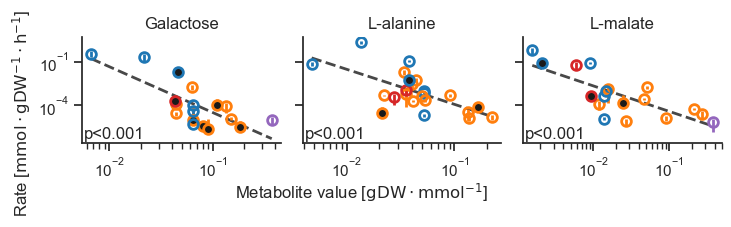

In [86]:
sns.set(font_scale = 1, style = 'ticks')
fig, axes = plt.subplots(1, 3, figsize = (8, 2), sharey=True, sharex=False)
for i, cs in enumerate(df_s['Carbon source'].unique()):
    nanidx = df_s[['log10(Metabolite value [gDW/mmol])','log10(Rate [mmol/gDW/h])']].isna().any(axis = 1)
    idxcs = (df_s['Carbon source'] == cs) & ~nanidx
    pcolors = df_s.loc[idxcs, 'Compound class'].map(cclass_color).values
    
    x = df_s.loc[idxcs, 'Metabolite value [gDW/mmol]'].values
    logx = df_s.loc[idxcs, 'log10(Metabolite value [gDW/mmol])'].values
    y = df_s.loc[idxcs, 'Rate [mmol/gDW/h]'].values
    logy = df_s.loc[idxcs, 'log10(Rate [mmol/gDW/h])'].values
    
    yierr = df_s.loc[idxcs, 'Std. Err [mmol/gDW/h]'].values
    yierr2 = np.array(list(zip(yierr, yierr))).T
    for j in range(idxcs.sum()):
        # axes[i].errorbar(x[j], y[j], yerr = yerr[:, j, np.newaxis], ls = 'none', marker = 'o', c = colors[j], zorder = 0, alpha = 0.8)
        yjerr = yierr2[:, j, np.newaxis]
        if yjerr[0] > y[j]:
            yjerr[0] = 0
            markerfacecolor = 'k'
        else:
            markerfacecolor = 'none'
        axes[i].errorbar(x[j], y[j], yerr = yjerr,  ls = 'none', marker = 'o', c = pcolors[j], zorder = 0, 
                         markeredgecolor=pcolors[j], markerfacecolor=markerfacecolor, 
                         markeredgewidth = 2, linewidth = 2, ms = 7,
                         ecolor = pcolors[j])# alpha = 0.8,
    axes[i].set_title(cs, fontsize=12)
    slope, intercept, rvalue, pvalue, _ = linregress(logx,logy)
    xarr, yarr, xarr10, yarr10 = linear_fit(slope, intercept, logx)
    axes[i].plot(xarr10, yarr10, ls = '--', c = 'k', lw = 2, zorder=-1, alpha = 0.8)
    # axes[i].annotate(fr'$\rho$ = {rvalue:.2f}', (0.65, 0.9), xycoords = 'axes fraction')
    # axes[i].annotate(fr'p-val = {pvalue:.0e}', (0.56, 0.8), xycoords = 'axes fraction')
    axes[i].annotate(fr'p<0.001', (0.01, 0.01), xycoords = 'axes fraction', ha = 'left', va = 'bottom')
    axes[i].set_yscale('log')
    axes[i].set_xscale('log')
    # sns.regplot(x = logx, y = logy, scatter = False, color = 'gray', ax = axes[i], line_kws={'ls':'--', 'lw': 2})#, truncate=False

# axes[0].set_ylabel(r'$\rm{log}_{10}$(Rate [mmol/gDW/h])')
fig.supylabel(r'Rate [$\rm{mmol \cdot gDW^{-1} \cdot h^{-1}}$]', x = 0.06, size = 12)
# axes[3].set_ylim([1e-5, 1])

# axes[1].set_xlim([0.015, 0.25])
# axes[0].set_ylim(-6, 1.5)
sns.despine()
fig.supxlabel(r'Metabolite value [$\rm{gDW \cdot mmol^{-1}}$]', y = 0.05, size = 12)
# plt.tight_layout()
# plt.subplots_adjust(hspace = 0.4, left=0.15, bottom=0.3)
plt.subplots_adjust(wspace = 0.11, hspace = 0.3, left=0.15, right=0.95, top=0.88, bottom=0.35)

plt.savefig(figure_folder / '1_sintef rates.pdf')
# sns.scatterplot(data = df_no_cg_p, x = 'log10(Metabolite value [gDW/mmol])', y = 'log10(Rate [mmol/gDW/h])')
# p = sns.relplot(data = df_no_cg_p, x = 'log10(Metabolite value [gDW/mmol])', y = 'log10(Rate [mmol/gDW/h])', col = 'Species', col_wrap=3, hue = 'Compound class', s = 100, facet_kws={'sharex': False, 'sharey': False})

# Plot the vila 2023 dataset

In [89]:
df_v = df_rates.loc[df_rates.Dataset == 'Vila-23', :].sort_values(['Carbon source', 'Metabolite'])


In [90]:
strains = sorted(df_v.Species.unique())
cs_vila = sorted(df_v['Carbon source'].unique())

In [91]:
# Find carbon sources where all 4 species are present
species_per_cs = df_v.groupby('Carbon source')['Species'].nunique()
ncs_per_species = df_v.groupby('Species')['Carbon source'].nunique()
cs_per_species = df_v.groupby('Species')['Carbon source'].unique()
carbon_sources_with_all_species = species_per_cs[species_per_cs == 4].index.tolist()
species_per_cs


Carbon source
Acetate        2
D-Fructose     4
D-Galactose    1
D-Glucose      4
D-Ribose       1
Fumarate       1
Glycerol       4
L-Arabinose    1
L-Malate       4
Pyruvate       4
Succinate      1
Name: Species, dtype: int64

In [93]:
cs_per_species['Pputida']


array(['Acetate', 'D-Fructose', 'D-Glucose', 'Glycerol', 'L-Malate',
       'Pyruvate'], dtype=object)

In [94]:
cs_species_list = {
    'Ecoli':['D-Fructose', 'D-Glucose', 'Glycerol', 'L-Malate', 'Pyruvate', 'L-Arabinose', 'D-Galactose', 'D-Ribose'],
    'Enterobacter':['D-Fructose', 'D-Glucose', 'Glycerol', 'L-Malate', 'Pyruvate'],
    'Pputida': ['D-Fructose', 'D-Glucose', 'Glycerol', 'L-Malate', 'Pyruvate', 'Acetate'],
    'Pseudomonas':['D-Fructose', 'D-Glucose', 'Glycerol', 'L-Malate', 'Pyruvate', 'Acetate', 'Fumarate', 'Succinate'],
}
strain_name_mapping = {
    'Ecoli': 'E. coli',
    'Enterobacter': 'Enterobacter',
    'Pputida': 'P. putida',
    'Pseudomonas': 'Pseudomonas',
}

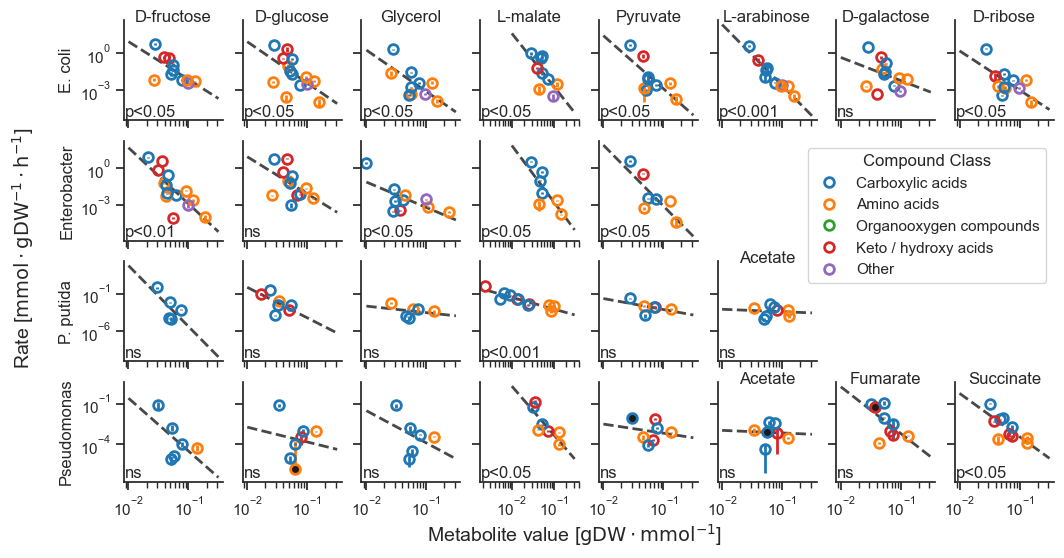

In [98]:
sns.set_theme(font_scale = 1, style = 'ticks')
fig, axes = plt.subplots(4,8, figsize = (12, 6), sharey='row', sharex='col')
for k, s in enumerate(strains):
    cs_list = cs_species_list[s]
    for i, cs in enumerate(cs_list):
        nanidx = df_v[['log10(Metabolite value [gDW/mmol])','log10(Rate [mmol/gDW/h])']].isna().any(axis = 1)
        idxcs = (df_v['Carbon source'] == cs) & ~nanidx & (df_v.Species==s)
        pcolors = df_v.loc[idxcs, 'Compound class'].map(cclass_color).values
        
        if np.sum(idxcs) == 0:
            continue
        x = df_v.loc[idxcs, 'Metabolite value [gDW/mmol]'].values
        logx = df_v.loc[idxcs, 'log10(Metabolite value [gDW/mmol])'].values
        y = df_v.loc[idxcs, 'Rate [mmol/gDW/h]'].values
        logy = df_v.loc[idxcs, 'log10(Rate [mmol/gDW/h])'].values
        
        yierr = df_v.loc[idxcs, 'Std. Err [mmol/gDW/h]'].values
        yierr2 = np.array(list(zip(yierr, yierr))).T
        for j in range(idxcs.sum()):
            # axes[i].errorbar(x[j], y[j], yerr = yerr[:, j, np.newaxis], ls = 'none', marker = 'o', c = colors[j], zorder = 0, alpha = 0.8)
            yjerr = yierr2[:, j, np.newaxis]
            if yjerr[0] > y[j]:
                yjerr[0] = 0
                markerfacecolor = 'k'
            else:
                markerfacecolor = 'none'
            axes[k,i].errorbar(x[j], y[j], yerr = yjerr,  ls = 'none', marker = 'o', c = pcolors[j], zorder = 0, 
                             markeredgecolor=pcolors[j], markerfacecolor=markerfacecolor, 
                             markersize = 7,markeredgewidth = 2,lw = 2,
                             ecolor = pcolors[j])# alpha = 0.8,
        if (k == 0) or ((k==3)&(i>4)) or ((k==2)&(i>4)):
            axes[k,i].set_title(cs.capitalize(), fontsize = 12, y = 0.9)
        if i == 0:
            axes[k,i].set_ylabel(strain_name_mapping[s], fontsize=12)
            axes[k,i].yaxis.set_label_position("left")
        slope, intercept, rvalue, pvalue, _ = linregress(logx,logy)
        xarr, yarr, xarr10, yarr10 = linear_fit(slope, intercept, logx, xmin = min(-2, np.round(logx.min(), 1)), xmax = -0.5)
        axes[k,i].plot(xarr10, yarr10, ls = '--', c = 'k', lw =2, zorder = -1, alpha = 0.8)
        # axes[k,i].annotate(fr'$\rho$ = {rvalue:.2f}', (0.65, 0.9), xycoords = 'axes fraction')
        if pvalue >= 0.05:
            axes[k,i].annotate('ns', (0.01, 0.01), xycoords = 'axes fraction', ha = 'left', va = 'bottom')
        elif 0.01 < pvalue < 0.05:
            axes[k,i].annotate('p<0.05', (0.01, 0.01), xycoords = 'axes fraction', ha = 'left', va = 'bottom')
        elif 0.001 < pvalue < 0.01:
            axes[k,i].annotate('p<0.01', (0.01, 0.01), xycoords = 'axes fraction', ha = 'left', va = 'bottom')
        else:
            axes[k,i].annotate('p<0.001', (0.01, 0.01), xycoords = 'axes fraction', ha = 'left', va = 'bottom')
        axes[k,i].set_yscale('log')
        axes[k,i].set_xscale('log')
    i += 1
        # axes[k,i].set_xlim(min(1e-2, xarr.min()*0.8), 1)
    while i < 8:
        axes[k,i].set_visible(False)
        i+=1
        
    # sns.regplot(x = logx, y = logy, scatter = False, color = 'gray', ax = axes[i], line_kws={'ls':'--', 'lw': 2})#, truncate=False

# axes[0].set_ylabel(r'$\rm{log}_{10}$(Rate [mmol/gDW/h])')
# axes[0].set_ylabel(r'Rate [$\rm{mmol \cdot gDW^{-1} \cdot h^{-1}}$]')
# axes[3].set_ylim([1e-5, 1])


# axes[1].set_xlim([0.015, 0.25])
# axes[0].set_ylim(-6, 1.5)
# axes[1,1].set_xlim(0.019, 0.2)
# axes[1,1].set_xticks([0.02, 0.1])
# axes[1,1].set_xticklabels([r'$2 \cdot 10^{-2}$', r'$10^{-1}$'])
sns.despine()
fig.supxlabel(r'Metabolite value [$\rm{gDW \cdot mmol^{-1}}$]', x = 0.5, y = 0, size = 14, ha = 'center')
fig.supylabel(r'Rate [$\rm{mmol \cdot gDW^{-1} \cdot h^{-1}}$]',y = 0.5,x = 0.03, size = 14, va = 'center')
plt.subplots_adjust(hspace = 0.2, wspace=0.2)
# plt.tight_layout()
# Create a legend for the compound classes
legend_handles = [
    mlines.Line2D([], [], color=color, marker='o', linestyle='None', markersize=7, label=compound_class, 
                  markeredgewidth=2, markerfacecolor='none')
    for compound_class, color in cclass_color.items()
]
fig.legend(
    handles=legend_handles,
    loc='upper right',
    bbox_to_anchor=(0.9, 0.68),
    ncol=1,
    title='Compound Class',
)
plt.savefig(figure_folder / '1_vila_2023_rates.pdf')
# sns.scatterplot(data = df_no_cg_p, x = 'log10(Metabolite value [gDW/mmol])', y = 'log10(Rate [mmol/gDW/h])')
# p = sns.relplot(data = df_no_cg_p, x = 'log10(Metabolite value [gDW/mmol])', y = 'log10(Rate [mmol/gDW/h])', col = 'Species', col_wrap=3, hue = 'Compound class', s = 100, facet_kws={'sharex': False, 'sharey': False})